# GAN으로 숫자 이미지 생성 

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

MNIST 학습용 Data Set 이용

In [2]:
# 학습 데이터와 테스트 데이터 분리
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


모든 값을 0~1 사이로 정규화

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

입력 데이터 평탄화

In [4]:
BATCH_SIZE=128
EPOCHS=2000
Z_DIMENSIONS=32
data = np.reshape(x_train, (x_train.shape[0], 28, 28, 1))

판별자 신경망 구축

In [5]:
def make_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='relu', input_shape=[28, 28, 1]))
  model.add(tf.keras.layers.Dropout(0.4))
  
  model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='relu'))
  model.add(tf.keras.layers.Dropout(0.4))
  
  model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', activation='relu'))
  model.add(tf.keras.layers.Dropout(0.4))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  return model

판별자 신경망 Compile

In [6]:
discriminator = make_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0004), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


생성자 신경망 구축

In [7]:
def make_generator():
  model = tf.keras.Sequential()
  
  model.add(tf.keras.layers.Dense(7*7*64, input_shape=(Z_DIMENSIONS,)))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Reshape((7, 7, 64)))
  model.add(tf.keras.layers.Dropout(0.4))
  
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2DTranspose(32, kernel_size=5, padding='same', activation=None,))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2DTranspose(16, kernel_size=5, padding='same', activation=None,))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
  model.add(tf.keras.layers.LeakyReLU())
  
  model.add(tf.keras.layers.Conv2D(1, kernel_size=5, padding='same', activation='sigmoid'))
  return model

생성자 생성 및 테스트

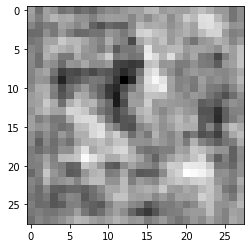

In [8]:
generator = make_generator()

noise = tf.random.normal([1, Z_DIMENSIONS])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

GAN 구축

In [9]:
z = tf.keras.layers.Input(shape=(Z_DIMENSIONS,))
fake_image = generator(z)
discriminator.trainable = False
prediction = discriminator(fake_image)
gan_model = tf.keras.models.Model(z, prediction)

gan_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0004), metrics=['accuracy'])

GAN 학습

1/1 [==============================] - 0s 267ms/step


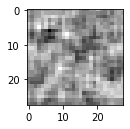

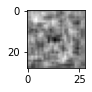

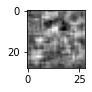

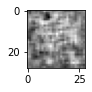

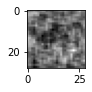

1/1 [==============================] - 0s 31ms/step


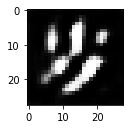

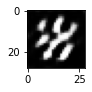

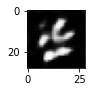

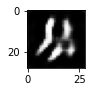

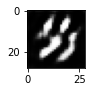

1/1 [==============================] - 0s 29ms/step


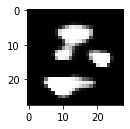

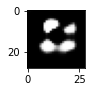

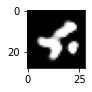

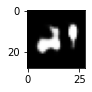

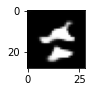

1/1 [==============================] - 0s 33ms/step


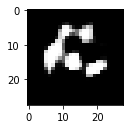

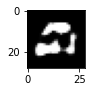

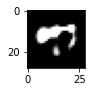

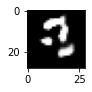

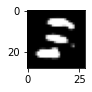

4/4 [==============================] - 0s 75ms/step


In [ ]:
def train_gan():
  for i in range(EPOCHS):
    real_images = np.reshape(data[np.random.choice(data.shape[0], BATCH_SIZE, replace=False)], (BATCH_SIZE,28,28,1))
    
    fake_images = generator.predict(np.random.uniform(-1.0, 1.0, size=[BATCH_SIZE, Z_DIMENSIONS]))
    
    x = np.concatenate((real_images,fake_images))
    y = np.ones([2*BATCH_SIZE,1])
    y[BATCH_SIZE:,:] = 0
    
    discriminator.train_on_batch(x, y)
    noise = np.random.uniform(-1.0, 1.0, size=[BATCH_SIZE, Z_DIMENSIONS])
    y = np.ones([BATCH_SIZE,1])
    
    gan_model.train_on_batch(noise, y)
    
    if i%100 == 0:
      noise = np.random.uniform(-1.0, 1.0, size=[5, Z_DIMENSIONS])
      generated_image = generator.predict(noise)
      plt.figure(figsize=(10,10))
      for i in range(generated_image.shape[0]):
        plt.subplot(1, 5, i+1)
        plt.imshow(generated_image[i, :, :, 0], cmap='gray')
        plt.show()
train_gan()